In [1]:
import pandas as pd
import os
import re
import numpy as np
from sentence_transformers import SentenceTransformer
import multiprocess 
from multiprocess import cpu_count
from multiprocess import Pool
from langdetect import detect_langs, DetectorFactory
DetectorFactory.seed = 42


In [2]:
path_ocrs = os.path.abspath("../datasets/predict_categories_dataset_ocrs.jsonl.gz")
path_products = os.path.abspath("../datasets/predict_categories_dataset_products.jsonl.gz")


In [3]:
def get_main_lang(dict_list):
    """ get the language that has the highest confidence in 'detectedLanguages' """
    max_v = 0
    main_lang = "not_found"
    for dict_ in dict_list:
        lang = dict_["languageCode"]
        if "confidence" in dict_:
            confidence = dict_["confidence"]
        else: confidence = -1
        if confidence > max_v:
            max_v = confidence
            main_lang = lang
    return main_lang, max_v


def get_row_for_df(json_line):
    """ extract items from json and returns a row to put in a dataframe """
    code = json_line['code']
    if "ocrs" in json_line:
        langs = []
        confidences = []
        texts = []
        keys =  list(json_line['ocrs'].keys())
        for key in keys:
            ocr_text = json_line['ocrs'][key]['text']
            detected_langs = json_line['ocrs'][key]['detectedLanguages']
            main_lang, confidence = get_main_lang(detected_langs)
            texts.append(ocr_text)
            langs.append(main_lang)
            confidences.append(confidence)
    row = [code, "<end_of_text> \n".join(texts),  confidences, langs, keys]
    return row


def get_row_for_df_v2(json_line):
    """ extract items from json and returns a row to put in a dataframe """
    code = json_line['code']
    if "ocrs" in json_line:
        langs = []
        confidences = []
        texts = []
        keys =  list(json_line['ocrs'].keys())
        for key in keys:
            ocr_text = json_line['ocrs'][key]['text']
            #detected_langs = json_line['ocrs'][key]['detectedLanguages']
            main_lang, sorted_dict = text_lang_split(ocr_text)
            text_main_lang = sorted_dict[main_lang]["text"]
            confidence = np.mean(sorted_dict[main_lang]["prob"])
 
            #main_lang, confidence = get_main_lang(detected_langs)
            texts.append(text_main_lang)
            langs.append(main_lang)
            confidences.append(confidence)
    row = [code, "<end_of_text> \n".join(texts),  confidences, langs, keys]
    return row

In [4]:
def artificial_sentence_split(text, n_words_per_sentence = 15):
    """splits artificially based on a pre-defined number of words. On average there are 15 words per sentence"""
    txt_split = text.split()
    total_words = len(txt_split)
    if total_words >= n_words_per_sentence:
        n_sentences = total_words // n_words_per_sentence
        rest = total_words % n_words_per_sentence
        chunks = [[i*n_words_per_sentence, (i+1)*n_words_per_sentence ] for i in range(n_sentences)]
        chunks[-1][1]+=rest
    else:
        chunks = [[0, total_words]]
    sentence_split = [" ".join(txt_split[slice(*chunk)]) for chunk in chunks]
    return sentence_split
    
def get_lang(text, threshold = 0.6):
    """takes text as input and returns main language detected if its probability is above the threshold"""
    main_lang = 'not_found'
    max_prob = 0
    try :
        langs = detect_langs(text)
        for lang in langs:
            if lang.prob > max(max_prob, threshold): 
                max_prob = lang.prob 
                main_lang = lang.lang
    except:
        main_lang = "not_found"
        max_prob = 0

    return main_lang, max_prob
    
def text_lang_split(text:str):
    """
    takes text as input and splits it in a dictionnary with languages as keys.
    for each language we have subkeys such as:
    text: text found with the given language
    len_text: the length of the text
    prob: a list of probabilities, each probability corresponds to a sentence.  
    """
    text = re.sub(r"\n", " ", text)
    text = re.sub("\.+", ".", text)
    lang_dict = {}
    for sentence in artificial_sentence_split(text):
        lang, prob = get_lang(sentence)
        if lang in lang_dict:
            lang_dict[lang]["prob"].append(prob)
            lang_dict[lang]["len_text"] += len(sentence)
            lang_dict[lang]["text"]+= sentence
            
        else:
            lang_dict[lang] = {}
            lang_dict[lang]["prob"] = [prob]
            lang_dict[lang]["len_text"] = len(sentence)
            lang_dict[lang]["text"] = sentence
            
    sorted_dict = {k: v for k, v in sorted(lang_dict.items(), key=lambda item: item[1]["len_text"], reverse = True)}
    main_lang = next(iter(sorted_dict))
    return main_lang, sorted_dict


In [601]:
i = np.random.choice(range(len(df)))
t = df.iloc[i,0]
barcode = df.index[i]
print(barcode)
t = re.sub(r"\n", " ", t)
t = re.sub("\.+", ".", t)
t


0253028036418


"Valeurs nutritionnelles moyennes pour 100 g : |Énergie Matières grasses dont acides gras saturés 826 kJ soit 198 kcal 12 g 2,3 g 0,6 g 0,6 g < 0,5 g 21 g Glucides dont sucres Fibres alimentaires Protéines Sel 2g  Saveurs FRANCRS JAMBON CUIT À L'ANCIENNE BLEU BLANC COEUR Ppale Cul chon b OGM09 Fprte en A consommer jungu 19.08.20 Numéro de Lot : 02020407 Prix/kg 19.90€ 0,279kg 5,55€ o 12536281036418 "

In [538]:
show_images_from_barcode(barcode)

In [602]:
artificial_sentence_split(t)[-1]

"L'ANCIENNE BLEU BLANC COEUR Ppale Cul chon b OGM09 Fprte en A consommer jungu 19.08.20 Numéro de Lot : 02020407 Prix/kg 19.90€ 0,279kg 5,55€ o 12536281036418"

In [5]:
import gzip
import json
#rows = []

with gzip.open(path_ocrs) as f:
    for i, line in enumerate(f):
        #if i > 10000: # first 10 000 lines are potentially problematic we keep only further lines
        if i > len(rows) - 1:
            json_line = json.loads(line)
            row = get_row_for_df_v2(json_line)
            rows.append(row)
df = pd.DataFrame(rows, columns = ["code", "texts", "confidences", "langs", "keys"])
print(df.shape)

In [32]:
json_line["ocrs"].keys()

dict_keys(['2', '1', '3'])

In [307]:
### Keep only real codes i.e codes with length = 13 characters.
real_codes =  df["code"].str.len() == 13
df = df[real_codes]
print("after removing non normalized codes", df.shape)
### Keep only texts > 10 char
len_sup_10 = (df["texts"].str.len()> 10)
df = df[len_sup_10]
print("after removing short texts", df.shape)


after removing non normalized codes (643360, 5)
after removing short texts (643360, 5)


In [308]:
def floor(x:int)->int:
    if x >= 1000:
        x = 1000
    return x
def make_score(confidences):
    if len(confidences)==1:
        malus = 0.7
    else:
        malus = 1
    return np.mean(confidences)*malus

def get_most_confident_lang(confidences, langs, texts):
    """
    get the language that has a good balance between confidence and length
    score = confidence_mean * text_len. if text_len > 600 then text_len = 600
    """
    D = {}
    for conf, lang, text in zip(confidences, langs, texts.split("<end_of_text> \n")):
        if lang in D:
            D[lang]["confidences"].append(conf)
            D[lang]["text_len"] += len(text)
        else:
            D[lang] = {}
            D[lang]["confidences"] = [conf]
            D[lang]["text_len"] = len(text)
    output_dict = {lang: make_score(D[lang]['confidences'])*floor(D[lang]['text_len']) for lang in D}
    lang_to_keep = max(output_dict, key = output_dict.get)
    lang_to_keep_confidence = np.mean(D[lang]["confidences"])
    return lang_to_keep, lang_to_keep_confidence, D, output_dict

def extract_text_with_lang(langs, lang_to_keep, text, split_key = "<end_of_text> \n"):
    to_pick = np.where(np.array(langs) ==lang_to_keep)[0]
    text_as_a_list = text.split(split_key)
    output_text = " ".join([text_as_a_list[i] for i in to_pick])
    return output_text

def extract_text_with_lang_from_df(df):
    extracted_texts = []
    lang_to_keep_list = []
    lang_to_keep_confidence_list = []
    for confidences, langs, texts in zip(df["confidences"], df["langs"], df["texts"]):
        lang_to_keep, lang_to_keep_confidence, _, _ = get_most_confident_lang(confidences, langs, texts)
        output_text = extract_text_with_lang(langs, lang_to_keep, texts, split_key = "<end_of_text> \n")
        #append items
        extracted_texts.append(output_text)
        lang_to_keep_list.append(lang_to_keep)
        lang_to_keep_confidence_list.append(lang_to_keep_confidence)
    return extracted_texts, lang_to_keep_list, lang_to_keep_confidence_list

In [309]:
index = 18241
c = df.loc[index, "confidences"]
l = df.loc[index, "langs"]
text = df.loc[index, "texts"]
print(df.loc[index, "confidences"])
print(df.loc[index, "langs"])
print(df.loc[index, "keys"])

[0.48, 0.66, 0.79, 0.56, 0.6, 0.46, 0.19, 0.88, 0.87, 1, 1, 1, 0.94]
['es', 'pt', 'it', 'en', 'no', 'en', 'de', 'no', 'en', 'hr', 'nl', 'de', 'en']
['13', '12', '11', '21', '17', '8', '9', '16', '20', '15', '18', '14', '4']


In [310]:

lang_to_keep, lang_to_keep_confidence, D, O = get_most_confident_lang(c, l, text)
print("lang_to_keep:", lang_to_keep)
print("lang_to_keep confidence:", lang_to_keep_confidence)
print(D)
print("--")
print(O)
output_text = extract_text_with_lang(l, lang_to_keep, text, split_key = "<end_of_text> \n")
print(output_text)

lang_to_keep: de
lang_to_keep confidence: 0.7075
{'es': {'confidences': [0.48], 'text_len': 121}, 'pt': {'confidences': [0.66], 'text_len': 101}, 'it': {'confidences': [0.79], 'text_len': 85}, 'en': {'confidences': [0.56, 0.46, 0.87, 0.94], 'text_len': 643}, 'no': {'confidences': [0.6, 0.88], 'text_len': 315}, 'de': {'confidences': [0.19, 1], 'text_len': 1313}, 'hr': {'confidences': [1], 'text_len': 30}, 'nl': {'confidences': [1], 'text_len': 28}}
--
{'es': 40.656, 'pt': 46.662, 'it': 47.004999999999995, 'en': 454.9225, 'no': 233.1, 'de': 595.0, 'hr': 21.0, 'nl': 19.599999999999998}
EN CONTAINS BARLEY MALT, WHEAT BEST BEFORE: SE
BOTTLENECK
DE ENTHALT: GERSTENMALZ, WEIZEN MINDESTENS HAITRAD
CH BIS SIEHE FLASCHENHALS IN CH IMPORTIERT VON
AT HEINEKEN SWITZERLAND AG, OBERGRUNDSTRASSE 110
CH-6002 LUZERN VOR WARME UND LICHT GESCHUTZT
LAGERN
FR CONTIENT MALT D'ORGE, BLE-A CONSOMMER DE
PREFERENCE AVANT LE: VOIR COL BIERE IMPORTEE PAR
HEINEKEN ENTREPRISE BP 43-92 502 RUEIL-MALMAISON
CEDEX
IT CO

In [317]:
extracted_texts, lang_to_keep_list, lang_to_keep_confidence_list = extract_text_with_lang_from_df(df)
df["extracted_text"] = extracted_texts
df["lang_kept"] = lang_to_keep_list
df["lang_kept_confidence"] = lang_to_keep_confidence_list
cols_order = ["code", "extracted_text", "lang_kept", "lang_kept_confidence", "texts", "langs", "confidences","keys"]
df = df[cols_order]
df = df.set_index('code', drop = True)
df

,extracted_text,lang_kept,lang_kept_confidence,texts,langs,confidences,keys
code,,,,,,,
0041498293222,"""Percent Daily Values are based on a 2000\nNut...",en,1.000000,"""Percent Daily Values are based on a 2000\nNut...",[en],[1],[1]
0041498310424,"INGREDIENTS: WHOLE ROLLED OATS,\nMILLED CANE S...",en,0.893333,"INGREDIENTS: WHOLE ROLLED OATS,\nMILLED CANE S...","[en, en, en]","[1, 0.75, 0.93]","[2, 1, 3]"
0041500007007,Réf 0361 Moutarde French jaune\nIngrédients: v...,fr,0.930000,1901\nSince\n100% NATURA\nClassic\nMUSTARD\n80...,"[en, fr]","[1, 0.93]","[1, 3]"
0041500007229,"INGREDIENTS: SPIRIT VINEGAR,\nWATER, MUSTARD S...",en,0.570000,"INGREDIENTS: SPIRIT VINEGAR,\nWATER, MUSTARD S...","[en, fr, en, en, en, en, de]","[0.84, 1, 0.54, 0.71, 0.7, 1, 0.57]","[8, 2, 9, 5, 7, 1, 6]"
0041500013107,Poids net:295 m\ninarédients: vinaiore distilé...,fr,0.900000,Poids net:295 m\ninarédients: vinaiore distilé...,"[fr, fr, en]","[1, 0.9, 0.9]","[2, 1, 3]"
...,...,...,...,...,...,...,...
0872513001795,Nestle\nCocoe\nPer bar\nEnergy\n192kcal\n10\nf...,en,0.825000,Nestle\nCocoe\nPer bar\nEnergy\n192kcal\n10\nf...,"[en, en]","[0.85, 0.8]","[1, 2]"
0040232618994,OLIVE OIL\nNutrition Facts\n133 Servings Per C...,en,0.900000,OLIVE OIL\nNutrition Facts\n133 Servings Per C...,"[en, en]","[0.85, 0.95]","[2, 1]"
0646670532245,FISH\nMARKET\nYarm Ruised\nTILAPIA\nFILLETS\n5...,en,0.810000,FISH\nMARKET\nYarm Ruised\nTILAPIA\nFILLETS\n5...,[en],[0.81],[1]


In [325]:
df.head(5)

,extracted_text,lang_kept,lang_kept_confidence,texts,langs,confidences,keys
code,,,,,,,
0041498293222,"""Percent Daily Values are based on a 2000\nNut...",en,1.000000,"""Percent Daily Values are based on a 2000\nNut...",[en],[1],[1]
0041498310424,"INGREDIENTS: WHOLE ROLLED OATS,\nMILLED CANE S...",en,0.893333,"INGREDIENTS: WHOLE ROLLED OATS,\nMILLED CANE S...","[en, en, en]","[1, 0.75, 0.93]","[2, 1, 3]"
0041500007007,Réf 0361 Moutarde French jaune\nIngrédients: v...,fr,0.930000,1901\nSince\n100% NATURA\nClassic\nMUSTARD\n80...,"[en, fr]","[1, 0.93]","[1, 3]"
0041500007229,"INGREDIENTS: SPIRIT VINEGAR,\nWATER, MUSTARD S...",en,0.570000,"INGREDIENTS: SPIRIT VINEGAR,\nWATER, MUSTARD S...","[en, fr, en, en, en, en, de]","[0.84, 1, 0.54, 0.71, 0.7, 1, 0.57]","[8, 2, 9, 5, 7, 1, 6]"
0041500013107,Poids net:295 m\ninarédients: vinaiore distilé...,fr,0.900000,Poids net:295 m\ninarédients: vinaiore distilé...,"[fr, fr, en]","[1, 0.9, 0.9]","[2, 1, 3]"


In [327]:
df.head(2)

,extracted_text,lang_kept,lang_kept_confidence,texts,langs,confidences,keys
code,,,,,,,
0041498293222,"""Percent Daily Values are based on a 2000\nNut...",en,1.000000,"""Percent Daily Values are based on a 2000\nNut...",[en],[1],[1]
0041498310424,"INGREDIENTS: WHOLE ROLLED OATS,\nMILLED CANE S...",en,0.893333,"INGREDIENTS: WHOLE ROLLED OATS,\nMILLED CANE S...","[en, en, en]","[1, 0.75, 0.93]","[2, 1, 3]"


In [334]:
show_images_from_barcode('0041500007007')
#df.loc['0041500007007', "keys"]

In [233]:
def text_cleaner(text):
  text_cleaned = text.replace("\n", " ") #remove line breaks
  #text_cleaned = re.sub("\w*([.])\w+", "", text_cleaned) #remove websites or measures
  text_cleaned = re.sub("[^A-Za-z0-9 \-àâäéèêëîïôöùûüÿçÂÊÎÔÛÄËÏÖÜÀÆæÇÉÈŒœÙ]", " ", text_cleaned) #kepp alphanum only
  text_cleaned = re.sub("\w*([0-9]{0,}[,|\.]{0,}[0-9])\w*", " ", text_cleaned) #remove measure elements
  text_cleaned = re.sub(r"\b([a-zA-Z]{1})\b", " ", text_cleaned) # remove isolated letters ex --> g g g g g
  text_cleaned = re.sub("( +- +)", " ", text_cleaned)
  text_cleaned = re.sub(r" +", " ", text_cleaned) # remove multiple spaces

  #text_cleaned = "".join([ch for ch in text_cleaned if (ch.isalnum() or ch == " " or ch =="'" or ch =="-")])
  return text_cleaned

In [234]:
df["text_cleaned"] = df["extracted_text"].apply(lambda x: text_cleaner(x))

In [237]:
text_cleaner(df.loc['3350033581098', "extracted_text"])

'MONOPRIX Gourmet VA Pralin NOS CONSEILS DE PRÉPARATION Sortez la bûchette de son emballage et déposez-la sur une assiette de présentation environ minutes avant de la déguster BÜCHETTES GLACÉES COMPOSÉES UNE CRÈME GLACÉE AU CHOCOLAT NOIR AVEC ÉCLATS DE CARAMEL AU BEURRE ET À LA CRÈME DÉCORÉES UN FLOCAGE AUX CHOCOLATS DE GANACHE AU CHOCOLAT NOIR ET DE CUBES DE CARAMEL AU LAIT SURGELÉES INGRÉDIENTS Crème glacée au chocolat noir avec éclats de caramel aromatique au beurre et à la crème lait entier sucre chocolat noir du Costa Rica à de cacao pâte de cacao du Costa Rica sucre beurre de cacao arôme naturel de vanille caramel aromatique au beurre et à la crème sucre sirop de glucose beurre crème eau crème fraîche cacao en poudre Afrique de Ouest -sirop de glucose déshydraté lait écrémé en poudre lactose et protéines de lait émulsifiant mono- et diglycérides acides gras-stabilisants farine de graines de caroube gomme guar Flocage aux chocolats chocolat au lait sucre beurre de cacao lait entie

In [220]:
#df = df.set_index("code", drop = True)

In [7]:
from tqdm import tqdm
def worker_cleaner(list_):
    return [text_cleaner(x) for x in list_]

def chunk_worker(chunk):
    text_cleaned_col_idx = np.where(df.columns == "text_cleaned")[0][0]
    text_list = df.iloc[chunk, text_cleaned_col_idx]
    return worker_cleaner(text_list)


In [12]:
chunks = np.array_split(range(df.shape[0]), cpu_count())
print(len(chunks))
print(len(chunks[0]))

4
109750


In [15]:
pool = Pool()
multiple_results = [pool.apply_async(chunk_worker, (chunks[i],)) for i in range(cpu_count())]
output = [r.get() for r in multiple_results]

IndexError: index 0 is out of bounds for axis 0 with size 0

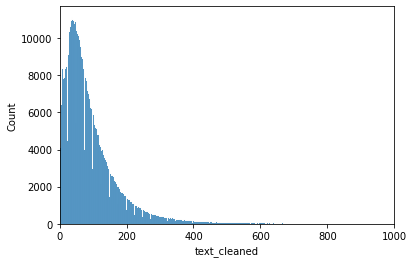

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
word_count = df['text_cleaned'].str.split().str.len()
sns.histplot(word_count)
plt.xlim([0,1000])
plt.show()


### TFIDF Trick

In [238]:
#fit on the whole french dataset
from sklearn.feature_extraction.text import TfidfVectorizer
df_fr = df[df["lang_kept"]== "fr"]
print(df_fr.shape)


(268282, 8)


In [235]:
#i = np.random.choice(range(df_fr.shape[0]))
i = 1
print(i)
print(df_fr["text_cleaned"].iloc[i])


1
America' Favourite Nothing adds more flavour Frenchs to more foods than the classic taste of FRENCHS Classic Yellow Mustard natural An American family favourite since it' introduction at the St Louis World' Fair in FRENCH' is great with hotdogs burgers ribs and steaks and is mild enouah to saueeze straight onto salads sandwiches and bagels VINEGAR ' SALT SPICE NDER Poi Inc ngrédients mou vinaigre 'alcooi eau graines de moutarde curcuma paprika épices arome pour dre ' Aconsommer de préférence avant voir emballage Distribué par MEDIASCORE SAS Cons www shoppingstreet Distributed bw FRENCHSFoots aunt of Reckt Benckiser Parsippany RB Reserved Made in USA lmported and Distributed by Bespoke FoodS London Distrbutoda Eurofood Spa-ConSCO MI ProdottoinUSA 


In [239]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 2, max_df = 0.8)
tfidf_matrix_fr = vectorizer.fit_transform(df_fr["text_cleaned"])
tfidf_matrix_fr

<268282x273288 sparse matrix of type '<class 'numpy.float64'>'
	with 18440050 stored elements in Compressed Sparse Row format>

In [240]:
def get_words_with_highest_scores(scores, words, n_words_to_take):
  """
  takes scores and words of an OCR as inputs and returns 
  words with highest tfidf scores
  """
  items = [item for item in sorted(zip(scores, words), reverse = True)]
  best_items = items[:n_words_to_take]
  return best_items, items

def get_words_and_scores_from_tfidf_matrix(doc, cols, tfidf_matrix_fr, index_to_word):
  """
  takes a document (line of tfidf matrix) and its words (columns of tfidf matrix
  and returns words of the documents with their ifidf scores
  columns are the non zero values of the tfidf matrix.
  """
  scores = []
  words = []
  for col in cols:
    word = index_to_word[col] 
    score = tfidf_matrix_fr[doc, col]
    words.append(word)
    scores.append(score)
  return words, scores

index_to_word = {index: word for index, word in zip(vectorizer.vocabulary_.values(), vectorizer.vocabulary_.keys())}

def text_selection(doc, index_to_word, df_cleaned, n_words_to_take = 35, tfidf_matrix_fr = tfidf_matrix_fr):
  rows, cols = tfidf_matrix_fr[doc].nonzero()
  ## extract words and scores from tfidf matrix
  words, scores = get_words_and_scores_from_tfidf_matrix(doc, cols, tfidf_matrix_fr, index_to_word)
  #extract words with highest score from sentence
  best_items, items = get_words_with_highest_scores(scores, words, n_words_to_take)
  best_words = [item[1] for item in best_items]
  text_selection = " ".join([word for word in df_cleaned.iloc[doc].split() if word.lower() in best_words])
  text_selection_unique = remove_duplicates(text_selection)
  return text_selection_unique, items

In [225]:
def remove_duplicates(text):
    D = {word.lower(): word  for word in str(text).split()}
    return " ".join(D.values())

In [241]:
from tqdm import tqdm
freq_dict = {}
for text in tqdm(df_fr["text_cleaned"]):
    for word in remove_duplicates(text).split():
        if str(word).lower() in freq_dict:
            freq_dict[str(word).lower()] += 1
        else:
            freq_dict[str(word).lower()] =1

100%|██████████| 268282/268282 [00:16<00:00, 16033.13it/s]


In [242]:
freq_dic_sorted = {k: v for k, v in sorted(freq_dict.items(), reverse = True, key=lambda item: item[1]) if v > 1}

In [329]:
from PIL import Image
import requests
import io

def make_barcode(x):
    return "{}/{}/{}/{}".format(x[:3], x[3:6], x[6:9], x[9:])

def make_link_from_barcode(barcode, file = "image", df= df):
    keys = df.loc[barcode, "keys"]
    links = []
    if file == "image": file = "jpg"
    if file == "json": file = "json"
    barcode_with_slash = make_barcode(barcode)
    for key in keys:
        link = "https://world.openfoodfacts.org/images/products/{}/{}.{}".format(barcode_with_slash, key,file)
        links.append(link)
    return links

def show_images(links):
    for link in links:
        response = requests.get(link)
        image_bytes = io.BytesIO(response.content)
        img = Image.open(image_bytes)
        img.show()

def show_images_from_barcode(barcode):
    links = make_link_from_barcode(barcode, file = "image")
    show_images(links)

In [287]:
show_images_from_barcode('0041500007229')

In [247]:
df_fr["extracted_text"].iloc[i]

"America's Favourite\nNothing adds more flavour\nFrenchs\nto more foods than the classic\ntaste of FRENCHS Classic\nYellow Mustard, 100% natural.\nAn American family favourite since it's\nintroduction at the St. Louis World's Fair in 1904!\nFRENCH'S is great with hotdogs, burgers, ribs and steaks and is\nmild enouah to saueeze straight onto salads, sandwiches and bagels.\nVINEGAR\n'n. SALT.\nSPICE,\nNDER\nPoi\nInc\nngrédients\nmou\nvinaigre d'alcooi,eau graines de moutarde.S\ncurcuma, paprika épices,arome, pour dre d'a\nAconsommer de préférence avant voir emballage\nDistribué par MEDIASCORE F00D SAS.\nA Cons\nwww.shoppingstreet\n0 41500 00722 9\nDistributed bw.FRENCHSFoots aunt of Reckt Benckiser\nParsippany NOTO54-0224 2011 RB.\nReserved Made in USA\nlmported and Distributed by Bespoke FoodS\nLondon SW81\nDistrbutoda Eurofood Spa-ConSCO (MI)\nProdottoinUSA\n0334756\n113345\n12 29\n"

In [243]:
df_fr["text_cleaned"].iloc[i]

'America Favourite Nothing adds more flavour Frenchs to more foods than the classic taste of FRENCHS Classic Yellow Mustard natural An American family favourite since it introduction at the St Louis World Fair in FRENCH is great with hotdogs burgers ribs and steaks and is mild enouah to saueeze straight onto salads sandwiches and bagels VINEGAR SALT SPICE NDER Poi Inc ngrédients mou vinaigre alcooi eau graines de moutarde curcuma paprika épices arome pour dre Aconsommer de préférence avant voir emballage Distribué par MEDIASCORE SAS Cons www shoppingstreet Distributed bw FRENCHSFoots aunt of Reckt Benckiser Parsippany RB Reserved Made in USA lmported and Distributed by Bespoke FoodS London Distrbutoda Eurofood Spa-ConSCO MI ProdottoinUSA '

In [244]:
text_selection(i, index_to_word, df_fr["text_cleaned"], n_words_to_take = 35)

('America favourite Nothing adds more FRENCHS to FoodS the Classic American introduction is hotdogs and straight onto salads sandwiches bagels NDER alcooi MEDIASCORE shoppingstreet Distributed bw aunt Benckiser RB Reserved lmported Bespoke London Eurofood',
 [(0.2905362628986267, 'frenchs'),
  (0.23920785611856749, 'favourite'),
  (0.20332923916603987, 'and'),
  (0.1768359684701444, 'distributed'),
  (0.1687359458434285, 'classic'),
  (0.16373014989214457, 'foods'),
  (0.14871808610258716, 'shoppingstreet'),
  (0.14871808610258716, 'hotdogs'),
  (0.14871808610258716, 'consco'),
  (0.14871808610258716, 'bespoke'),
  (0.14526813144931336, 'lmported'),
  (0.13855708033938752, 'benckiser'),
  (0.13695573881185694, 'mediascore'),
  (0.1320933008276743, 'eurofood'),
  (0.12864334617440049, 'straight'),
  (0.12791632069674017, 'alcooi'),
  (0.12723086284349164, 'introduction'),
  (0.12528068378077836, 'more'),
  (0.12378090819021786, 'aunt'),
  (0.12071169178925256, 'adds'),
  (0.119961932186

In [158]:
df_fr["tfidf_selection"] = [text_selection(i, index_to_word, df_fr["text_cleaned"])[0] for i in range(df_fr.shape[0])]

/var/folders/hv/qx8621252qs2m1jzhhzd4c1r0000gn/T/ipykernel_74806/4105742966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fr["tfidf_selection"] = [text_selection(i, index_to_word, df_fr["text_cleaned"])[0] for i in range(df_fr.shape[0])]


In [159]:
df_fr.head(2)

,extracted_text,lang_kept,lang_kept_confidence,texts,langs,confidences,keys,text_cleaned,tfidf_selection
code,,,,,,,,,
0041500007007,Réf 0361 Moutarde French jaune\nIngrédients: v...,fr,0.93,1901\nSince\n100% NATURA\nClassic\nMUSTARD\n80...,"[en, fr]","[1, 0.93]","[1, 3]",Réf Moutarde French jaune Ingrédients vinaigre...,Réf moutarde French jaune vinaigre distillé su...
0041500007229,America's Favourite\nNothing adds more flavour...,fr,0.57,"INGREDIENTS: SPIRIT VINEGAR,\nWATER, MUSTARD S...","[en, fr, en, en, en, en, de]","[0.84, 1, 0.54, 0.71, 0.7, 1, 0.57]","[8, 2, 9, 5, 7, 1, 6]",America' Favourite Nothing adds more flavour F...,favourite Nothing adds more FRENCHS to FoodS t...


In [335]:
barcode = "0041500007229"
#barcode = "0041500007007"
c = df.loc[barcode, "confidences"]
l = df.loc[barcode, "langs"]
texts = df.loc[barcode, "texts"]

lang_to_keep, lang_to_keep_confidence, D, O = get_most_confident_lang(c, l, texts)
print(lang_to_keep)
print(lang_to_keep_confidence)
print(O)
print(D)

en
0.57
{'en': 748.146, 'fr': 601.3, 'de': 132.867}
{'en': {'confidences': [0.84, 0.54, 0.71, 0.7, 1], 'text_len': 987}, 'fr': {'confidences': [1], 'text_len': 859}, 'de': {'confidences': [0.57], 'text_len': 333}}


In [206]:
i = 1
df_fr.loc[i_l[i], "extracted_text"]

"America's Favourite\nNothing adds more flavour\nFrenchs\nto more foods than the classic\ntaste of FRENCHS Classic\nYellow Mustard, 100% natural.\nAn American family favourite since it's\nintroduction at the St. Louis World's Fair in 1904!\nFRENCH'S is great with hotdogs, burgers, ribs and steaks and is\nmild enouah to saueeze straight onto salads, sandwiches and bagels.\nVINEGAR\n'n. SALT.\nSPICE,\nNDER\nPoi\nInc\nngrédients\nmou\nvinaigre d'alcooi,eau graines de moutarde.S\ncurcuma, paprika épices,arome, pour dre d'a\nAconsommer de préférence avant voir emballage\nDistribué par MEDIASCORE F00D SAS.\nA Cons\nwww.shoppingstreet\n0 41500 00722 9\nDistributed bw.FRENCHSFoots aunt of Reckt Benckiser\nParsippany NOTO54-0224 2011 RB.\nReserved Made in USA\nlmported and Distributed by Bespoke FoodS\nLondon SW81\nDistrbutoda Eurofood Spa-ConSCO (MI)\nProdottoinUSA\n0334756\n113345\n12 29\n"

In [207]:
df_fr.loc[i_l[i], "text_cleaned"]

"America' Favourite Nothing adds more flavour Frenchs to more foods than the classic taste of FRENCHS Classic Yellow Mustard natural An American family favourite since it' introduction at the St Louis World' Fair in FRENCH' is great with hotdogs burgers ribs and steaks and is mild enouah to saueeze straight onto salads sandwiches and bagels VINEGAR ' SALT SPICE NDER Poi Inc ngrédients mou vinaigre 'alcooieau graines de moutardeS curcuma paprika épicesarome pour dre ' Aconsommer de préférence avant voir emballage Distribué par MEDIASCORE SAS Cons wwwshoppingstreet Distributed bwFRENCHSFoots aunt of Reckt Benckiser Parsippany RB Reserved Made in USA lmported and Distributed by Bespoke FoodS London Distrbutoda Eurofood Spa-ConSCO MI ProdottoinUSA "

In [209]:
i_l = df_fr.index
print(i_l[i])
df_fr.loc[i_l[i], "tfidf_selection"]

0041500007229


KeyError: 'tfidf_selection'

In [214]:
vectorizer.vocabulary_["moutardes"]

169825

In [210]:
text_selection(i, index_to_word, df_fr["text_cleaned"], n_words_to_take = 35)

('favourite Nothing adds more FRENCHS to FoodS the Classic Yellow American introduction is hotdogs ribs and straight onto salads sandwiches bagels NDER épicesarome MEDIASCORE Distributed aunt Benckiser RB Reserved lmported Bespoke London Eurofood',
 [(0.3017027937185185, 'frenchs'),
  (0.24263921208818504, 'favourite'),
  (0.20682285999900923, 'and'),
  (0.18248503528531385, 'distributed'),
  (0.1713466223732942, 'classic'),
  (0.16632610990714453, 'foods'),
  (0.15085139685925925, 'épicesarome'),
  (0.15085139685925925, 'hotdogs'),
  (0.15085139685925925, 'consco'),
  (0.15085139685925925, 'bespoke'),
  (0.14735195377075383, 'lmported'),
  (0.14054463489746055, 'benckiser'),
  (0.13892032266612847, 'mediascore'),
  (0.13504656473997786, 'eurofood'),
  (0.1304886915615031, 'straight'),
  (0.1290559466338886, 'introduction'),
  (0.1271149641092729, 'more'),
  (0.1260742102876143, 'aunt'),
  (0.12325451231580807, 'adds'),
  (0.1216827456192326, 'onto'),
  (0.11904231385321881, 'nothing')